In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
!pip install torch torchvision albumentations opencv-python xmltodict matplotlib

In [6]:
import os
import cv2
import torch
import torchvision
import numpy as np
import xml.etree.ElementTree as ET
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [15]:
class PascalVOC_Dataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, "JPEGImages")
        self.annotation_dir = os.path.join(root_dir, "Annotations")
        self.split = split
        self.transform = transform

        # Read image filenames
        split_file = os.path.join(root_dir, "ImageSets/Main", f"{split}.txt")
        with open(split_file, "r") as f:
            self.image_filenames = [line.strip() for line in f.readlines()]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, f"{filename}.jpg")
        ann_path = os.path.join(self.annotation_dir, f"{filename}.xml")

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Parse annotation XML
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes, labels = [], []
        for obj in root.findall("object"):
            label = obj.find("name").text
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Single class for now

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transform:
            image = self.transform(image)

        return image, target

In [9]:
transform = T.Compose([T.ToTensor()])
dataset_root = "/kaggle/input/pascal-voc-2007-dataset/VOCdevkit2007/VOC2007"
dataset = PascalVOC_Dataset(root_dir=dataset_root, split="train", transform=transform)

data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [12]:
import torch
import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torch.nn as nn

class FastRCNNPredictor(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_channels, num_classes)
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4)

    def forward(self, x):
        return self.cls_score(x), self.bbox_pred(x)

def load_fast_rcnn_with_transfer(device="cpu"):
    # Pascal VOC has 20 object classes + 1 background
    num_classes = 21  

    # Load ResNet backbone with FPN (Feature Pyramid Network)
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)
    
    # Create Fast R-CNN model
    model = FastRCNN(backbone, num_classes=num_classes)
    
    # Freeze all layers first
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last ResNet layers
    for param in model.backbone.body.layer4.parameters():
        param.requires_grad = True

    # Unfreeze ROI heads
    for param in model.roi_heads.parameters():
        param.requires_grad = True

    # Replace classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model.to(device)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = load_fast_rcnn_with_transfer(device=device)

# Verify which layers are trainable
print("\nTrainable layers:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Trainable layers:
backbone.body.layer4.0.conv1.weight
backbone.body.layer4.0.conv2.weight
backbone.body.layer4.0.conv3.weight
backbone.body.layer4.0.downsample.0.weight
backbone.body.layer4.1.conv1.weight
backbone.body.layer4.1.conv2.weight
backbone.body.layer4.1.conv3.weight
backbone.body.layer4.2.conv1.weight
backbone.body.layer4.2.conv2.weight
backbone.body.layer4.2.conv3.weight
roi_heads.box_head.fc6.weight
roi_heads.box_head.fc6.bias
roi_heads.box_head.fc7.weight
roi_heads.box_head.fc7.bias
roi_heads.box_predictor.cls_score.weight
roi_heads.box_predictor.cls_score.bias
roi_heads.box_predictor.bbox_pred.weight
roi_heads.box_predictor.bbox_pred.bias


In [10]:
import torch
import torchvision.transforms as T
from torchvision.datasets import VOCDetection

# Pascal VOC Classes Mapping
VOC_CLASSES = {
    "aeroplane": 1, "bicycle": 2, "bird": 3, "boat": 4, "bottle": 5,
    "bus": 6, "car": 7, "cat": 8, "chair": 9, "cow": 10,
    "diningtable": 11, "dog": 12, "horse": 13, "motorbike": 14, "person": 15,
    "pottedplant": 16, "sheep": 17, "sofa": 18, "train": 19, "tvmonitor": 20
}

# Transformations
transform = T.Compose([
    T.ToTensor(),
    T.Resize((600, 600))
])

# Custom Pascal VOC Dataset Wrapper
class CustomVOC(torch.utils.data.Dataset):
    def __init__(self, root, year="2007", image_set="train", transform=None):
        self.dataset = VOCDetection(root=root, year=year, image_set=image_set, download=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, target = self.dataset[idx]

        # Convert image
        if self.transform:
            image = self.transform(image)

        # Convert bounding boxes & labels
        boxes = []
        labels = []
        for obj in target["annotation"]["object"]:
            bbox = obj["bndbox"]
            xmin, ymin, xmax, ymax = map(int, [bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"]])
            boxes.append([xmin, ymin, xmax, ymax])

            # Map class names to integer labels
            class_name = obj["name"]
            if class_name in VOC_CLASSES:
                labels.append(VOC_CLASSES[class_name])
            else:
                print(f"Warning: Unknown class '{class_name}', skipping.")  # Debugging

        # Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        return image, {"boxes": boxes, "labels": labels}

# Load dataset
dataset = CustomVOC(root="./data", year="2007", image_set="train", transform=transform)

# DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Test loading
sample_images, sample_targets = next(iter(data_loader))
print(f"✅ Sample loaded! Image Shape: {sample_images[0].shape}, Target Example: {sample_targets[0]}")


Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
✅ Sample loaded! Image Shape: torch.Size([3, 600, 600]), Target Example: {'boxes': tensor([[  1.,  28., 246., 375.],
        [223.,  31., 500., 375.]]), 'labels': tensor([15, 15])}


In [1]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))


CUDA Available: True
Number of GPUs: 2
GPU Name: Tesla T4


In [20]:
# Step 6: Train Fast R-CNN (3 epochs) and Save Final Model
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
scaler = torch.cuda.amp.GradScaler()
num_epochs = 3  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():  
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += losses.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(data_loader):.4f}")

# Save the final model after training
torch.save(model.state_dict(), "fastrcnn_final_model.pth")
print("Training complete! Final model saved to fastrcnn_final_model.pth")

<ipython-input-20-465168467a7a>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-20-465168467a7a>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/3], Loss: 0.5585
Epoch [2/3], Loss: 0.5505
Epoch [3/3], Loss: 0.5485
Training complete! Final model saved to fastrcnn_final_model.pth


In [22]:
import numpy as np

In [26]:

# Step 7: Evaluate Fast R-CNN
def evaluate_fast_rcnn(model, dataloader, device):
    model.eval()
    all_preds, all_gts = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes = output["boxes"].cpu()
                pred_scores = output["scores"].cpu()
                gt_boxes = target["boxes"].cpu()

                all_preds.append((pred_boxes, pred_scores))
                all_gts.append(gt_boxes)

    return all_preds, all_gts


In [27]:

# Step 8: Calculate mAP for Fast R-CNN
def calculate_map_fast_rcnn(all_preds, all_gts, iou_threshold=0.5):
    if not all_preds or not all_gts:
        print("No valid predictions or ground truths available.")
        return 0.0

    all_ap = []
    for (pred_boxes, pred_scores), gt_boxes in zip(all_preds, all_gts):
        if len(gt_boxes) == 0:
            continue

        ious = torchvision.ops.box_iou(pred_boxes, gt_boxes)
        matches = ious > iou_threshold

        tp = torch.zeros(len(pred_boxes))
        fp = torch.zeros(len(pred_boxes))

        for i, match in enumerate(matches):
            if match.any():
                tp[i] = 1
            else:
                fp[i] = 1

        tp_cumsum = torch.cumsum(tp, dim=0)
        fp_cumsum = torch.cumsum(fp, dim=0)

        precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
        recall = tp_cumsum / len(gt_boxes)

        ap = torch.trapz(precision, recall)
        all_ap.append(ap.item())

    return sum(all_ap) / len(all_ap) if all_ap else 0.0



In [30]:
# Step 8: Evaluate Fast R-CNN
def evaluate_fast_rcnn(model, dataloader, device):
    model.eval()
    all_preds = []
    all_gts = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes = output["boxes"].cpu()
                pred_scores = output["scores"].cpu()
                gt_boxes = target["boxes"].cpu()

                all_preds.append((pred_boxes, pred_scores))
                all_gts.append(gt_boxes)

    return all_preds, all_gts

# Run Evaluation
all_preds, all_gts = evaluate_fast_rcnn(model, data_loader, device)

if all_preds and all_gts:
    map_score = calculate_map_fast_rcnn(all_preds, all_gts)
    print(f"Mean Average Precision (mAP): {map_score:.4f}")
else:
    print("Evaluation failed.")


Mean Average Precision (mAP): 0.7161


In [31]:
MODEL_PATH="/kaggle/input/fasterrcnnaug/fastrcnn_final_model.pth"
 model = FastRCNN(backbone, num_classes=num_classes)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

NameError: name 'load_faster_rcnn' is not defined

In [33]:
import torch
import torchvision

def load_fast_rcnn(num_classes=2, device="cuda"):
    # Load pre-trained Fast R-CNN model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Replace the classifier head for our number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    # Move model to device (CPU/GPU)
    model.to(device)
    return model


In [37]:
# Define model path
MODEL_PATH="/kaggle/working/fastrcnn_final_model.pth"
model = load_fast_rcnn(num_classes=21, device="cuda")
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


<ipython-input-37-54df81bc5ded>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


<All keys matched successfully>

In [38]:
import time
import numpy as np
import torch
from sklearn.metrics import precision_recall_fscore_support  

In [39]:
import time

def calculate_fps_fast_rcnn(model, dataloader, device, num_batches=50):
    """Calculate FPS for Fast R-CNN model"""
    model.eval()
    
    # Warmup
    with torch.no_grad():
        for i, (images, _) in enumerate(dataloader):
            if i >= 2:  # 2 warmup batches
                break
            images = [img.to(device) for img in images]
            _ = model(images)
    
    # Timed measurement
    start_time = time.time()
    with torch.no_grad():
        for i, (images, _) in enumerate(dataloader):
            if i >= num_batches:
                break
            images = [img.to(device) for img in images]
            _ = model(images)
    
    fps = num_batches / (time.time() - start_time)
    return fps

# Usage:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fps = calculate_fps_fast_rcnn(model, data_loader, device)  
print(f"FPS (Fast R-CNN): {fps:.1f}")


FPS (Fast R-CNN): 2.3


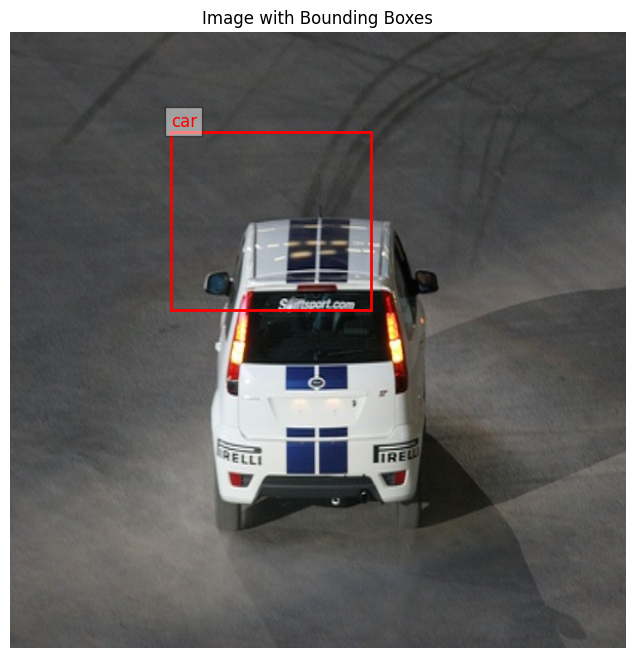

In [46]:
def visualize_image_with_boxes(image, targets, title="Image with Bounding Boxes"):
    """Visualize image with ground truth bounding boxes."""
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import matplotlib.patches as patches

    # Pascal VOC class mapping (ensure it's correct)
    VOC_CLASSES = {
        1: "aeroplane", 2: "bicycle", 3: "bird", 4: "boat", 5: "bottle",
        6: "bus", 7: "car", 8: "cat", 9: "chair", 10: "cow",
        11: "diningtable", 12: "dog", 13: "horse", 14: "motorbike", 15: "person",
        16: "pottedplant", 17: "sheep", 18: "sofa", 19: "train", 20: "tvmonitor"
    }

    # Convert image tensor to numpy
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()  # Corrected permutation

    # Create figure
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    # Draw bounding boxes
    for box, label in zip(targets["boxes"], targets["labels"]):
        xmin, ymin, xmax, ymax = box.cpu().numpy()

        # Handle unknown labels safely
        class_name = VOC_CLASSES.get(label.item() if isinstance(label, torch.Tensor) else label, "Unknown")

        rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor="red", facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, class_name, color="red", fontsize=12, bbox=dict(facecolor="white", alpha=0.5))

    plt.title(title)
    plt.axis("off")
    plt.show()

# Test with sample image
visualize_image_with_boxes(sample_image, sample_target)
